# AMS 595 Group Project: Identifying Risk Factors for Major Depressive Disorder

### Abby Bindelglass, Jane Condon, Nicholas Tardugno, Sydney Walters-Diaz

## Data Preparation

In [1]:
pip install catboost

### Importing Necessary Libraries

In [2]:
# Insert libraries here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay,
    classification_report, brier_score_loss
)
from sklearn.calibration import calibration_curve
import lightgbm as lgb
from catboost import CatBoostClassifier

### Importing the Data

In [3]:
# Reading the dataset into python using pandas
df = pd.read_csv("mhcld_puf_2023.csv", low_memory=False)

In [4]:
# Looking at the first few rows to ensure that the data has been imported correctly
df.head()

,YEAR,AGE,EDUC,ETHNIC,RACE,SEX,SPHSERVICE,CMPSERVICE,OPISERVICE,RTCSERVICE,...,ODDFLG,PDDFLG,PERSONFLG,SCHIZOFLG,ALCSUBFLG,OTHERDISFLG,STATEFIP,DIVISION,REGION,CASEID
0,2023,4,-9,3,5,2,2,1,1,2,...,0,0,0,0,0,0,1,6,3,20230000001
1,2023,5,4,4,3,2,1,2,2,2,...,0,0,0,1,0,0,1,6,3,20230000002
2,2023,8,4,4,5,2,1,1,2,2,...,0,0,0,1,0,0,1,6,3,20230000003
3,2023,11,-9,3,5,2,2,1,2,2,...,0,0,0,0,0,1,1,6,3,20230000004
4,2023,3,3,4,5,2,1,1,2,2,...,0,0,0,0,0,0,1,6,3,20230000005


### Data Preprocessing

#### Mapping For Easier Readability

As shown above, the readability of the data is very poor, as is often seen with large survey data. To make the data easier to interpret and understand, we will map our variables to the values/explanations provided in the codebook. We will start with the target variable, "DEPRESSFLG".

In [5]:
# Target variable: depressive disorder variable map

depressflg_map = {
    1: "Depressive disorder reported",
    0: "Not reported"
}


We can also map the predictor variables into something that is easier to understand. We start with the co-occurring mental health disorder variables. Since the values have the same meaning for each of the variables, (i.e., 0 = disorder reported, 1 = disorder not reported), we can combine them into a single map.

In [6]:
# Predictor map: co-occurring mental health disorders map

disorder_flags = ["ANXIETYFLG", "ADHDFLG", "CONDUCTFLG", "DELIRDEMFLG", "BIPOLARFLG",
         "ODDFLG", "PDDFLG", "PERSONFLG", "SCHIZOFLG", "OTHERDISFLG",
         "TRAUSTREFLG", "ALCSUBFLG"]

binary_flag_map = {1: "Reported", 0: "Not reported"}

For our next predictor variable, substance use disorder, we have two variables that we may use:

* SAP (binary): Gives a value of 1 if substance use disorder present, 2 if substance use disorder not present, and 0 if the response to this survey question is missing.
* SUB (numeric): Gives a value of 1-13 indicating a client's substance use diagnosis during the reporting period (e.g., 9 = alcohol abuse, 10 = cocaine abuse), or a value of -9 for a missing/invalid diagnosis.

Since the category codes of these variables are different from those of the co-occurring mental health disorder variables and are NOT binary, we must create a separate map. We can use the SAP variable to construct a simple yes/no variable indicating whether or not a survey respondent has been diagnosed with any type of substance use disorder. If we want to look into this further, the SUB variable indicates WHICH substance use disorder an individual has been diagnosed with.

In [7]:
# Predictor map: substance use map (SUB)

sub_use_map = {
    1: "Trauma/stressor disorder",
    2: "Anxiety disorder",
    3: "Attention deficit/hyperactivity disorder (ADHD)",
    4: "Conduct disorder",
    5: "Delirium/dementia disorder",
    6: "Bipolar disorder",
    7: "Depressive disorder",
    8: "Oppositional defiant disorder",
    9: "Pervasive developmental disorder",
    10: "Personality disorder",
    11: "Schizophrenia/psychotic disorder",
    12: "Alcohol or Substance Use Disorder",
    13: "Other disorder",
    -9: "Missing",
    -8: "Not applicable"
}


In [8]:
# Predictor map: substance use map (SAP)
sap_map = {
    1: "Substance use problem reported",
    0: "No substance use problem reported",
    -9: "Missing",
    -8: "Not applicable"
}

# Applying to SAP column:
df["SAP_LABEL"] = df["SAP"].map(sap_map)

# Creating into a simple yes/no binary variable
df["HAS_SAP"] = df["SAP"].isin([1]).astype(int)

Some other useful predictor variables that we can map are age, sex, education status, marital status, residential status, veteran status, employment status, race/ethnicity, and geographic region (in the U.S.).

In [9]:
# Predictor map: age

age_map = {
    1: "0–11",
    2: "12–14",
    3: "15–17",
    4: "18–20",
    5: "21–24",
    6: "25–29",
    7: "30–34",
    8: "35–39",
    9: "40–44",
    10: "45–49",
    11: "50–54",
    12: "55–59",
    13: "60–64",
    14: "65+",
    -9: "Missing",
    -8: "Not applicable"
}


In [10]:
# Predictor map: sex
sex_map = {
    1: "Male",
    2: "Female",
    -9: "Missing",
    -8: "Not applicable"
}


In [11]:
# Predictor map: education level
educ_map = {
    1: "Special education",
    2: "8 years or less",
    3: "9–11 years",
    4: "12 years or GED",
    5: "13 years or more",
    -9: "Missing",
    -8: "Not applicable"
}


In [12]:
# Predictor map: marital status
marstat_map = {
    1: "Never married",
    2: "Now married",
    3: "Separated",
    4: "Divorced or widowed",
    -9: "Missing",
    -8: "Not applicable"
}


In [13]:
# Predictor map: residential status
livarag_map = {
    1: "Experiencing homelessness",
    2: "Private residence",
    3: "Other",
    -9: "Missing",
    -8: "Not applicable"
}


In [14]:
# Predictor map: veteran status
veteran_map = {
    1: "Veteran",
    2: "Not a veteran",
    -9: "Missing",
    -8: "Not applicable"
}


In [15]:
# Predictor map: employment status
employ_map = {
    1: "Full-time",
    2: "Part-time",
    3: "Employed (not differentiated)",
    4: "Unemployed",
    5: "Not in labor force",
    -9: "Missing",
    -8: "Not applicable"
}

In [16]:
# Predictor map: ethnicity
ethnic_map = {
    1: "Hispanic or Latino",
    2: "Not Hispanic or Latino",
    -9: "Missing",
    -8: "Not applicable"
}

In [17]:
# Predictor map: race
race_map = {
    1: "White",
    2: "Black or African American",
    3: "American Indian or Alaska Native",
    4: "Asian",
    5: "Native Hawaiian or Pacific Islander",
    6: "Multiracial",
    -9: "Missing",
    -8: "Not applicable"
}

In [18]:
region_map = {
    1: "Northeast",
    2: "Midwest",
    3: "South",
    4: "West"
}

#### Creating a Pre-Processing Function

Next, we can create a pre-processing function that:
* Applies every mapping dictionary to the dataframe
* Creates binary flags (simple yes/no variable for appropriate variables)
* Handles missing values (using median/mode imputation)
* Returns a numeric dataframe for modeling, as well as a labeled dataframe that is easier to read/interpret

In [19]:
def preprocess_data(df):

    # Dealing with missing SAMHSA codes
    missing_codes = [-9, -8, -7, -6]
    df = df.replace(missing_codes, np.nan)

    # Preserving disorder flags as numeric
    for f in disorder_flags:
        if f in df.columns:
            df[f] = df[f].fillna(0).astype(int)

    # Preserving SUB and SAP as numeric predictors
    if "SUB" in df.columns:
        df["SUB"] = df["SUB"].fillna(0).astype(int)
    if "SAP" in df.columns:
        df["SAP"] = df["SAP"].fillna(0).astype(int)

    # Dropping unnecessary columns
    id_cols = ["CASEID", "STATEFIP"]
    df = df.drop(columns=[col for col in id_cols if col in df.columns])

    predictor_vars = [
        "AGE", "SEX", "EDUC", "MARSTAT", "LIVARAG",
        "VETERAN", "EMPLOY", "ETHNIC", "RACE",
        "SUB", "SAP", "REGION"
    ] + disorder_flags

    # Debugging: checking for missing predictor vars
    missing = [col for col in predictor_vars if col not in df.columns]
    if missing:
        print("Missing predictor columns:", missing)

    # Applying predictor selection
    df = df[[col for col in df.columns if col in predictor_vars or col == "DEPRESSFLG"]]

    # Applying mappings to the dataframe
    df["AGE_LABEL"] = df["AGE"].map(age_map)
    df["SEX_LABEL"]  = df["SEX"].map(sex_map)
    df["EDUC_LABEL"] = df["EDUC"].map(educ_map)
    df["MARSTAT_LABEL"] = df["MARSTAT"].map(marstat_map)
    df["LIVARAG_LABEL"] = df["LIVARAG"].map(livarag_map)
    df["VETERAN_LABEL"] = df["VETERAN"].map(veteran_map)
    df["EMPLOY_LABEL"] = df["EMPLOY"].map(employ_map)
    df["ETHNIC_LABEL"] = df["ETHNIC"].map(ethnic_map)
    df["RACE_LABEL"] = df["RACE"].map(race_map)

    df["REGION_LABEL"] = df["REGION"].map(region_map)

    df["SUB_LABEL"] = df["SUB"].map(sub_use_map)
    df["SAP_LABEL"] = df["SAP"].map(sap_map)
    df["DEPRESS_LABEL"] = df["DEPRESSFLG"].map(depressflg_map)

    for f in disorder_flags:
        df[f + "_LABEL"] = df[f].map(binary_flag_map)

    # Creating binary modeling flags (simple yes/no binary variables)
    df["HAS_SUBSTANCE_USE"] = (df["SUB"] == 12).astype(int)
    df["HAS_SAP"] = (df["SAP"] == 1).astype(int)
    df["MDD"] = (df["DEPRESSFLG"] == 1).astype(int)
    df["ANY_OTHER_MH_DISORDER"] = df[disorder_flags].fillna(0).max(axis=1)
    df["IS_VETERAN"] = (df["VETERAN"] == 1).astype(int)
    df["IS_HOMELESS"] = (df["LIVARAG"] == 1).astype(int)
    df["IS_MARRIED"] = (df["MARSTAT"] == 2).astype(int)

    # Using one-hot encoding for categorical variables
    categ_cols = [
        "AGE_LABEL", "SEX_LABEL", "EDUC_LABEL", "MARSTAT_LABEL",
        "LIVARAG_LABEL", "VETERAN_LABEL", "EMPLOY_LABEL",
        "ETHNIC_LABEL", "RACE_LABEL",
        "SUB_LABEL", "SAP_LABEL", "REGION_LABEL"
    ]

    model_df = pd.get_dummies(df.copy(), columns=categ_cols, drop_first=True)

    # Removing all columns containing "_LABEL" (including dummy-expanded ones)
    label_cols = [c for c in model_df.columns if "_LABEL" in c]
    model_df = model_df.drop(columns=label_cols, errors="ignore")

    # Handling missing values using imputation
    num_cols = model_df.select_dtypes(include=["float64", "int64"]).columns
    cat_cols = model_df.select_dtypes(include=["object", "category"]).columns

    # For numerical variables: median imputation
    num_imputer = SimpleImputer(strategy="median")
    model_df[num_cols] = num_imputer.fit_transform(model_df[num_cols])

    # For categorical variables: mode imputation
    if len(cat_cols) > 0:
        cat_imputer = SimpleImputer(strategy="most_frequent")
        model_df[cat_cols] = cat_imputer.fit_transform(model_df[cat_cols])

    return df, model_df


In [ ]:
# Calling the function
clean_df, model_df = preprocess_data(df)
model_df.isna().sum().sum() # Ensuring that missing values have been dealt with

#### Constructing Target Vector and Predictor Matrix

In [ ]:
# Target variable
y = model_df["MDD"]

In [ ]:
# Predictors matrix
X = model_df.drop(columns=["MDD", "DEPRESSFLG"], errors="ignore")

#### Splitting Data into Training, Validation and Test Set

In [ ]:
model_df = model_df.reset_index(drop=True)

In [ ]:
# Splitting into training and test set
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

In [ ]:
# Splitting training set into training and validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.20, random_state=42, stratify=y_train_full
)

## Exploratory Data Analysis

In [ ]:
# Sydney's section

## Data Visualization

In [ ]:
# Nick's section

In [ ]:
model_df.head()
model_df.keys()

Index(['AGE', 'EDUC', 'ETHNIC', 'RACE', 'SEX', 'SUB', 'MARSTAT', 'SAP',
       'EMPLOY', 'VETERAN', 'LIVARAG', 'TRAUSTREFLG', 'ANXIETYFLG', 'ADHDFLG',
       'CONDUCTFLG', 'DELIRDEMFLG', 'BIPOLARFLG', 'DEPRESSFLG', 'ODDFLG',
       'PDDFLG', 'PERSONFLG', 'SCHIZOFLG', 'ALCSUBFLG', 'OTHERDISFLG',
       'REGION', 'HAS_SUBSTANCE_USE', 'HAS_SAP', 'MDD',
       'ANY_OTHER_MH_DISORDER', 'IS_VETERAN', 'IS_HOMELESS', 'IS_MARRIED'],
      dtype='object')

In [ ]:
cols = ['AGE', 'EDUC', 'ETHNIC', 'RACE', 'SEX', 'SUB', 'MARSTAT', 'SAP',
       'EMPLOY', 'VETERAN', 'LIVARAG', 'TRAUSTREFLG', 'ANXIETYFLG', 'ADHDFLG',
       'CONDUCTFLG', 'DELIRDEMFLG', 'BIPOLARFLG', 'DEPRESSFLG', 'ODDFLG',
       'PDDFLG', 'PERSONFLG', 'SCHIZOFLG', 'ALCSUBFLG', 'OTHERDISFLG',
       'REGION', 'HAS_SUBSTANCE_USE', 'HAS_SAP', 'MDD',
       'ANY_OTHER_MH_DISORDER', 'IS_VETERAN', 'IS_HOMELESS', 'IS_MARRIED']

[print(c, set(model_df[c].to_list())) for c in cols]


AGE {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0}
EDUC {1.0, 2.0, 3.0, 4.0, 5.0}
ETHNIC {1.0, 2.0, 3.0, 4.0}
RACE {1.0, 2.0, 3.0, 4.0, 5.0, 6.0}
SEX {1.0, 2.0}
SUB {0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0}
MARSTAT {1.0, 2.0, 3.0, 4.0}
SAP {0.0, 1.0, 2.0}
EMPLOY {1.0, 2.0, 3.0, 4.0, 5.0}
VETERAN {1.0, 2.0}
LIVARAG {1.0, 2.0, 3.0}
TRAUSTREFLG {0.0, 1.0}
ANXIETYFLG {0.0, 1.0}
ADHDFLG {0.0, 1.0}
CONDUCTFLG {0.0, 1.0}
DELIRDEMFLG {0.0, 1.0}
BIPOLARFLG {0.0, 1.0}
DEPRESSFLG {0.0, 1.0}
ODDFLG {0.0, 1.0}
PDDFLG {0.0, 1.0}
PERSONFLG {0.0, 1.0}
SCHIZOFLG {0.0, 1.0}
ALCSUBFLG {0.0, 1.0}
OTHERDISFLG {0.0, 1.0}
REGION {3.0, 4.0}
HAS_SUBSTANCE_USE {0.0, 1.0}
HAS_SAP {0.0, 1.0}
MDD {0.0, 1.0}
ANY_OTHER_MH_DISORDER {0.0, 1.0}
IS_VETERAN {0.0, 1.0}
IS_HOMELESS {0.0, 1.0}
IS_MARRIED {0.0, 1.0}


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

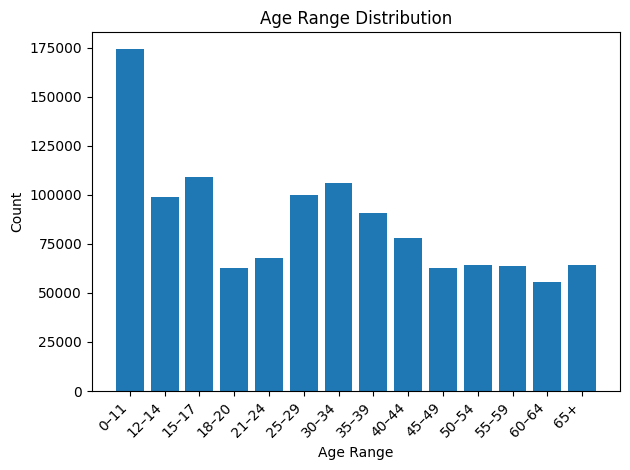

In [ ]:
# Histogram of AGE
mapped = model_df["AGE"].map(age_map)

counts = mapped.value_counts().reindex(age_map.values())[:14]

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Age Range")
plt.ylabel("Count")
plt.title("Age Range Distribution")
plt.tight_layout()
plt.show()

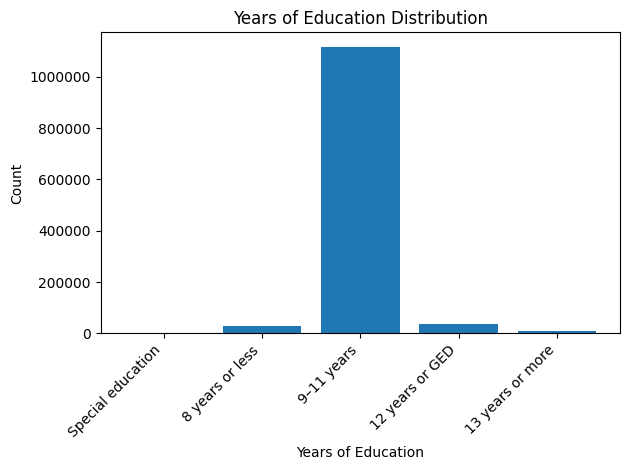

In [ ]:
# Histogram of EDUC
mapped = model_df["EDUC"].map(educ_map)

counts = mapped.value_counts().reindex(educ_map.values())

plt.bar(counts.index, counts.values)
plt.ticklabel_format(style='plain', axis="y")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Years of Education")
plt.ylabel("Count")
plt.title("Years of Education Distribution")
plt.tight_layout()
plt.show()

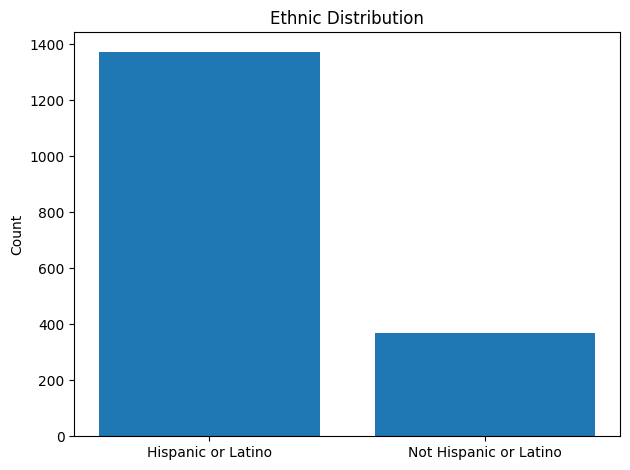

In [ ]:
# Histogram of ETHNIC
mapped = model_df["ETHNIC"].map(ethnic_map)

counts = mapped.value_counts().reindex(ethnic_map.values())

plt.bar(counts.index, counts.values)
plt.ylabel("Count")
plt.title("Ethnic Distribution")
plt.tight_layout()
plt.show()


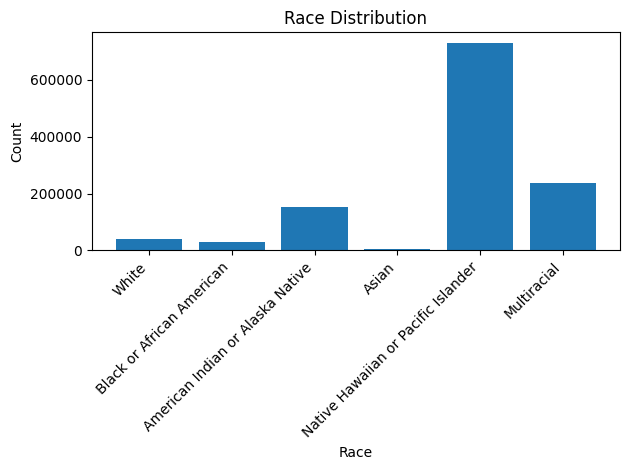

In [ ]:
# Histogram of RACE
mapped = model_df["RACE"].map(race_map)

counts = mapped.value_counts().reindex(race_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Race")
plt.ylabel("Count")
plt.title("Race Distribution")
plt.tight_layout()
plt.show()

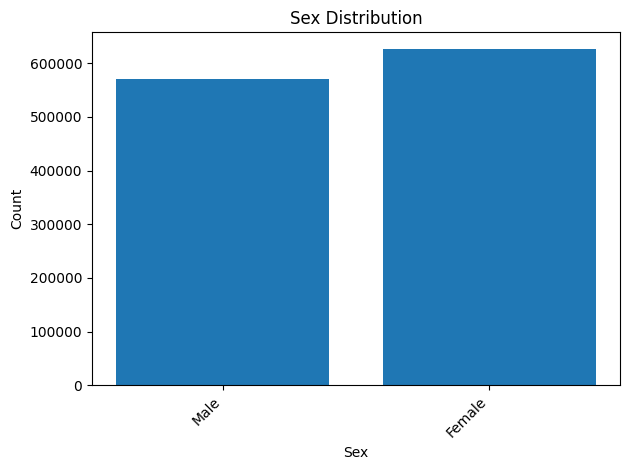

In [ ]:
# Histogram of SEX
mapped = model_df["SEX"].map(sex_map)

counts = mapped.value_counts().reindex(sex_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.title("Sex Distribution")
plt.tight_layout()
plt.show()

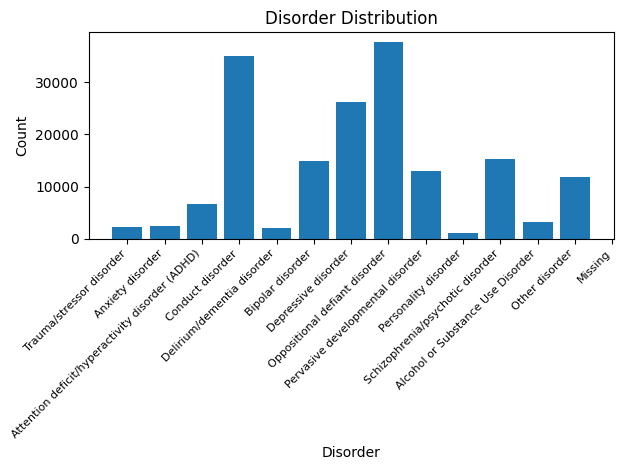

In [ ]:
# Histogram of SUB

mapped = model_df["SUB"].map(sub_use_map)

counts = mapped.value_counts().reindex(sub_use_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.xlabel("Disorder")
plt.ylabel("Count")
plt.title("Disorder Distribution")
plt.tight_layout()
plt.show()

In [ ]:
# Histogram of MARSTAT

mapped = model_df["MARSTAT"].map(marstat_map)

counts = mapped.value_counts().reindex(marstat_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Marital Status")
plt.ylabel("Count")
plt.title("Marital Status Distribution")
plt.tight_layout()
plt.show()

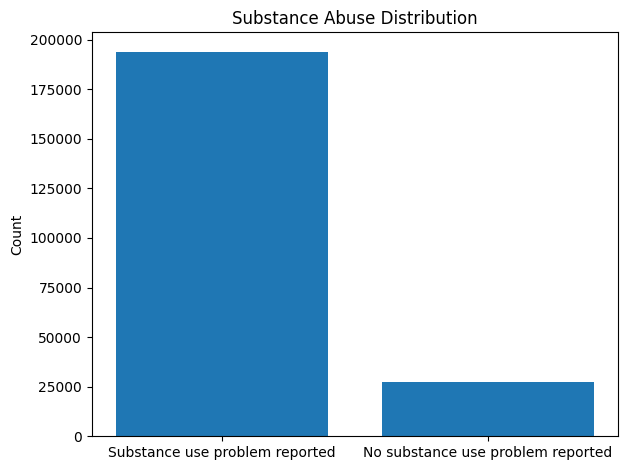

In [ ]:
# Histogram of SAP
mapped = model_df["SAP"].map(sap_map)

counts = mapped.value_counts().reindex(sap_map.values())

plt.bar(counts.index, counts.values)
plt.xlabel("")
plt.ylabel("Count")
plt.title("Substance Abuse Distribution")
plt.tight_layout()
plt.show()


In [ ]:
# Histogram of EMPLOY

mapped = model_df["EMPLOY"].map(employ_map)

counts = mapped.value_counts().reindex(employ_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Employment Status")
plt.ylabel("Count")
plt.title("Employment Status Distribution")
plt.tight_layout()
plt.show()


In [ ]:
# Histogram of VETERAN

mapped = model_df["VETERAN"].map(veteran_map)

counts = mapped.value_counts().reindex(veteran_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Veteran Status")
plt.ylabel("Count")
plt.title("Veteran Status Distribution")
plt.tight_layout()
plt.show()


In [ ]:
# Histogram of LIVARAG

mapped = model_df["LIVARAG"].map(livarag_map)

counts = mapped.value_counts().reindex(livarag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Residential Status")
plt.ylabel("Count")
plt.title("Residential Status Distribution")
plt.tight_layout()
plt.show()

In [ ]:
# Histogram of REGION

mapped = model_df["AGE"].map(region_map)

counts = mapped.value_counts().reindex(region_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Region")
plt.ylabel("Count")
plt.title("Region Distribution")
plt.tight_layout()
plt.show()


In [ ]:
# Histogram of ANXIETYFLG

mapped = model_df["ANXIETYFLG"].map(binary_flag_map)

counts = mapped.value_counts().reindex(binary_flag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Anxiety")
plt.ylabel("Count")
plt.title("Anxiety Distribution")
plt.tight_layout()
plt.show()


In [ ]:
# Histogram of ADHDFLG

mapped = model_df["ADHDFLG"].map(binary_flag_map)

counts = mapped.value_counts().reindex(binary_flag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("ADHD")
plt.ylabel("Count")
plt.title("ADHD Distribution")
plt.tight_layout()
plt.show()


In [ ]:
# Histogram of CONDUCTFLG

mapped = model_df["CONDUCTFLG"].map(binary_flag_map)

counts = mapped.value_counts().reindex(binary_flag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Conduct Disorder")
plt.ylabel("Count")
plt.title("Conduct Disorder Distribution")
plt.tight_layout()
plt.show()


In [ ]:
# Histogram of DELIRDEMFLG

mapped = model_df["DELIRDEMFLG"].map(binary_flag_map)

counts = mapped.value_counts().reindex(binary_flag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Delirium")
plt.ylabel("Count")
plt.title("Delirium Distribution")
plt.tight_layout()
plt.show()


In [ ]:
# Histogram of BIPOLARFLG

mapped = model_df["BIPOLARFLG"].map(binary_flag_map)

counts = mapped.value_counts().reindex(binary_flag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Bipolar Disorder")
plt.ylabel("Count")
plt.title("Bipolar Disorder Distribution")
plt.tight_layout()
plt.show()


In [ ]:
# Histogram of ODDFLG

mapped = model_df["ODDFLG"].map(binary_flag_map)

counts = mapped.value_counts().reindex(binary_flag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("ODD")
plt.ylabel("Count")
plt.title("ODD Distribution")
plt.tight_layout()
plt.show()


In [ ]:
# Histogram of PDDFLG

mapped = model_df["PDDFLG"].map(binary_flag_map)

counts = mapped.value_counts().reindex(binary_flag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("PDD")
plt.ylabel("Count")
plt.title("PDD Distribution")
plt.tight_layout()
plt.show()


In [ ]:
# Histogram of PERSONFLG

mapped = model_df["PERSONFLG"].map(binary_flag_map)

counts = mapped.value_counts().reindex(binary_flag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Personality Disorder")
plt.ylabel("Count")
plt.title("Personality Disorder Distribution")
plt.tight_layout()
plt.show()


In [ ]:
# Histogram of SCHIZOFLG

mapped = model_df["SCHIZOFLG"].map(binary_flag_map)

counts = mapped.value_counts().reindex(binary_flag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Schizophrenia")
plt.ylabel("Count")
plt.title("Schizophrenia Distribution")
plt.tight_layout()
plt.show()


In [ ]:
# Histogram of OTHERDISFLG

mapped = model_df["OTHERDISFLG"].map(binary_flag_map)

counts = mapped.value_counts().reindex(binary_flag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Other Disorder")
plt.ylabel("Count")
plt.title("Other Disorder Distribution")
plt.tight_layout()
plt.show()


In [ ]:
# Histogram of TRAUSTREFLG

mapped = model_df["TRAUSTREFLG"].map(binary_flag_map)

counts = mapped.value_counts().reindex(binary_flag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("")
plt.ylabel("Count")
plt.title("Distribution")
plt.tight_layout()
plt.show()


In [ ]:
# Histogram of HAS_SUBSTANCE_USE

mapped = model_df["HAS_SUBSTANCE_USE"].map(binary_flag_map)

counts = mapped.value_counts().reindex(binary_flag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Substance Abuse")
plt.ylabel("Count")
plt.title("Substance Abuse Distribution")
plt.tight_layout()
plt.show()


In [ ]:
# Histogram of HAS_SAP

mapped = model_df["HAS_SAP"].map(binary_flag_map)

counts = mapped.value_counts().reindex(binary_flag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Substance Abuse Map")
plt.ylabel("Count")
plt.title("Substance Abuse Distribution")
plt.tight_layout()
plt.show()


In [ ]:
# Histogram of MDD

mapped = model_df["MDD"].map(binary_flag_map)

counts = mapped.value_counts().reindex(binary_flag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("MDD")
plt.ylabel("Count")
plt.title("MDD Distribution")
plt.tight_layout()
plt.show()


In [ ]:
# Histogram of ANY_OTHER_MH_DISORDER

mapped = model_df["ANY_OTHER_MH_DISORDER"].map(binary_flag_map)

counts = mapped.value_counts().reindex(binary_flag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Any Other Mental Health Disorder")
plt.ylabel("Count")
plt.title("Any Other Mental Health Disorder Distribution")
plt.tight_layout()
plt.show()


In [ ]:
# Histogram of IS_VETERAN

mapped = model_df["IS_VETERAN"].map(binary_flag_map)

counts = mapped.value_counts().reindex(binary_flag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Veteran Status")
plt.ylabel("Count")
plt.title("Veteran Status Distribution")
plt.tight_layout()
plt.show()


In [ ]:
# Histogram of IS_HOMELESS

mapped = model_df["IS_HOMELESS"].map(binary_flag_map)

counts = mapped.value_counts().reindex(binary_flag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Homelessness Status")
plt.ylabel("Count")
plt.title("Homelessness Status Distribution")
plt.tight_layout()
plt.show()


In [ ]:
# Histogram of IS_MARRIED

mapped = model_df["IS_MARRIED"].map(binary_flag_map)

counts = mapped.value_counts().reindex(binary_flag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Marital Status")
plt.ylabel("Count")
plt.title("Marital Status Distribution")
plt.tight_layout()
plt.show()


## Logistic Regression

In [ ]:
# Abby's section

## Predictive Modeling

### Random Forest Model

In [ ]:
# Defining random forest model
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    max_features="sqrt",
    n_jobs=-1,
    class_weight="balanced",
    random_state=42
)


In [ ]:
# Fitting random forest model
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15, n_estimators=200,
                       n_jobs=-1, random_state=42)

In [ ]:
# Making predictions on test data
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

### Stochastic Gradient Descent (SGD) Model

Since we are unable to use a support vector machine model with data of this size, we implement a stochastic gradient descent model instead.

In [ ]:
# Scaling the data and fitting the model
sgd = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("sgd", SGDClassifier(
        loss="log_loss",
        max_iter=1000,
        tol=1e-3,
        random_state=42
    ))
])

In [ ]:
# Fitting the model
sgd.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler(with_mean=False)),
                ('sgd', SGDClassifier(loss='log_loss', random_state=42))])

In [ ]:
# Making predictions on test data
y_pred = sgd.predict(X_test)

### Light Gradient Boosting Machine (LIGHTGBM) Model

In [ ]:
# Defining LIGHTBGM model
lgbm = lgb.LGBMClassifier(
    num_leaves=64,
    learning_rate=0.05,
    n_estimators=500,
    min_child_samples=50,
    subsample=0.8,
    colsample_bytree=0.8
)

In [ ]:
# Fitting LIGHTBGM model
lgbm.fit(X_train, y_train,eval_set=[(X_val, y_val)],eval_metric="auc")

C:\Users\janec\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\janec\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\janec\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\janec\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\janec\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

[LightGBM] [Info] Number of positive: 1210878, number of negative: 3291931
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.166327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 112
[LightGBM] [Info] Number of data points in the train set: 4502809, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.268916 -> initscore=-1.000129
[LightGBM] [Info] Start training from score -1.000129


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, min_child_samples=50,
               n_estimators=500, num_leaves=64, subsample=0.8)

In [ ]:
# Making predictions on test data
y_pred = lgbm.predict(X_test)
y_prob = lgbm.predict_proba(X_test)[:,1]

### CatBoost Model

In [ ]:
# Defining CatBoost model
cat = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.03,
    depth=6,
    od_type="Iter",
    od_wait=40,
    task_type="CPU",
    verbose=100
)


In [ ]:
# Fitting CatBoost model
cat.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    use_best_model=True
)


0:	learn: 0.6769341	test: 0.6770942	best: 0.6770942 (0)	total: 417ms	remaining: 13m 53s
100:	learn: 0.4567744	test: 0.4570695	best: 0.4570695 (100)	total: 27.3s	remaining: 8m 32s
200:	learn: 0.4417571	test: 0.4421576	best: 0.4421576 (200)	total: 51.7s	remaining: 7m 43s
300:	learn: 0.4361152	test: 0.4365285	best: 0.4365285 (300)	total: 1m 15s	remaining: 7m 4s
400:	learn: 0.4321004	test: 0.4325332	best: 0.4325332 (400)	total: 1m 38s	remaining: 6m 33s
500:	learn: 0.4295342	test: 0.4299651	best: 0.4299651 (500)	total: 2m 2s	remaining: 6m 5s
600:	learn: 0.4275060	test: 0.4279479	best: 0.4279479 (600)	total: 2m 25s	remaining: 5m 39s
700:	learn: 0.4255967	test: 0.4260498	best: 0.4260498 (700)	total: 2m 49s	remaining: 5m 13s
800:	learn: 0.4240489	test: 0.4245080	best: 0.4245080 (800)	total: 3m 13s	remaining: 4m 49s
900:	learn: 0.4228366	test: 0.4233054	best: 0.4233054 (900)	total: 3m 36s	remaining: 4m 24s
1000:	learn: 0.4215286	test: 0.4219993	best: 0.4219993 (1000)	total: 4m	remaining: 4m
110

In [ ]:
# Making predictions on test data
y_pred = cat.predict(X_test)
y_prob = cat.predict_proba(X_test)[:, 1]

### Saving Models

In [ ]:
# Saving models
joblib.dump(rf, "random_forest_model.pkl")
joblib.dump(sgd, "sgd_model.pkl")
joblib.dump(lgbm, "lightgbm_model.pkl")

NameError: name 'rf' is not defined

In [ ]:
# Loading models
rf = joblib.load("random_forest_model.pkl")
sgd = joblib.load("sgd_model.pkl")
lgbm = joblib.load("lightgbm_model.pkl")

In [ ]:
# Saving CatBoost model
cat.save_model("catboost_model.cbm")

In [ ]:
# Loading CatBoost model
cat = CatBoostClassifier()
cat.load_model("catboost_model.cbm")

## Model Evaluation

### Creating a 'Model Evaluation Function'

In [ ]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    print(f"\n{model_name}")

    # Making predictions on the testing set
    y_pred = model.predict(X_test)

    # Obtaining probabilities (if possible)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
        # Converting scores to 0–1 using min-max scaling
        y_prob = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())
    else:
        y_prob = None

    # Displaying evaluation metrics
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))

    if y_prob is not None:
        print("AUC:", roc_auc_score(y_test, y_prob))
        print("Brier Score:", brier_score_loss(y_test, y_prob))

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Displaying Confusion Matrix
    con_mat = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        con_mat,
        annot=True,
        fmt="d",
        cmap="Blues",
        linewidths=.5,
        linecolor='black'
    )
    plt.title(f"{model_name} - Confusion Matrix", fontsize=14)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

    # Displaying ROC Curve
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, y_prob)
        plt.figure(figsize=(7,6))
        plt.plot(fpr, tpr, color="#5b3eb5", linewidth=2.5, label=f"AUC = {auc:.3f}")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=1.5)
        plt.title(f"{model_name} - ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(frameon=True)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    # Displaying Calibration Curve
    if y_prob is not None:
        prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
        plt.figure(figsize=(7,6))
        plt.plot(prob_pred, prob_true, marker="o", linestyle="-", color="#5887b0", linewidth=2)
        plt.plot([0, 1], [0, 1], "--", color="gray", linewidth=1.5)
        plt.title(f"{model_name} - Calibration Curve")
        plt.xlabel("Predicted Probability")
        plt.ylabel("Actual Probability")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    # Displaying Probability Curve
    if y_prob is not None:
        plt.figure(figsize=(7,6))
        sns.histplot(y_prob, bins=30, kde=True, color="#819bd4")

        plt.title(f"{model_name} - Predicted Probability Distribution", fontsize=15)
        plt.xlabel("Predicted Probability")
        plt.ylabel("Count")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    return y_pred, y_prob


### Evaluating Each Model


Random Forest
Accuracy: 0.7346426660242238
Precision: 0.5041199118101944
Recall: 0.8097093023255814
F1 Score: 0.6213754081405017
AUC: 0.8357657177826181
Brier Score: 0.16987452493060898

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.71      0.80   1028729
           1       0.50      0.81      0.62    378400

    accuracy                           0.73   1407129
   macro avg       0.71      0.76      0.71   1407129
weighted avg       0.80      0.73      0.75   1407129



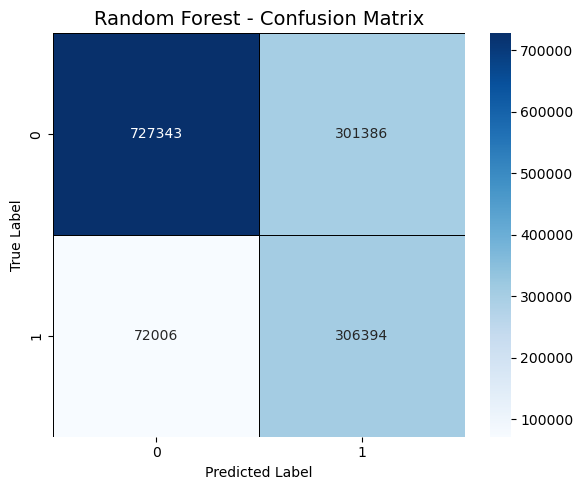

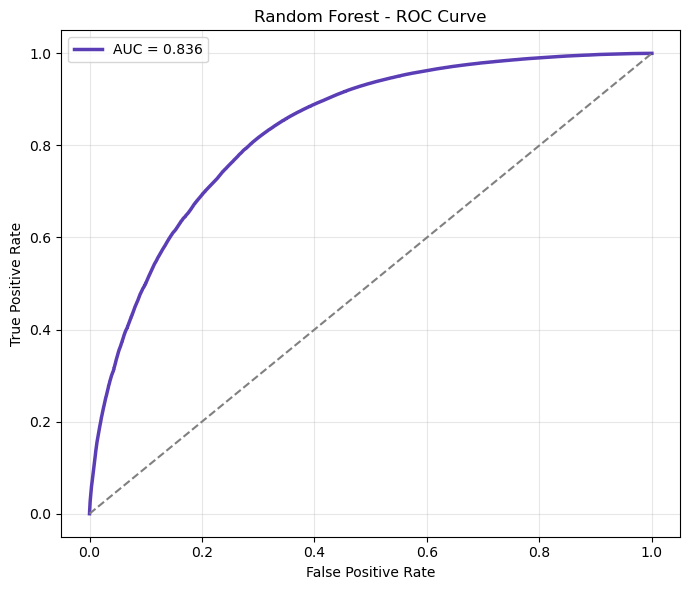

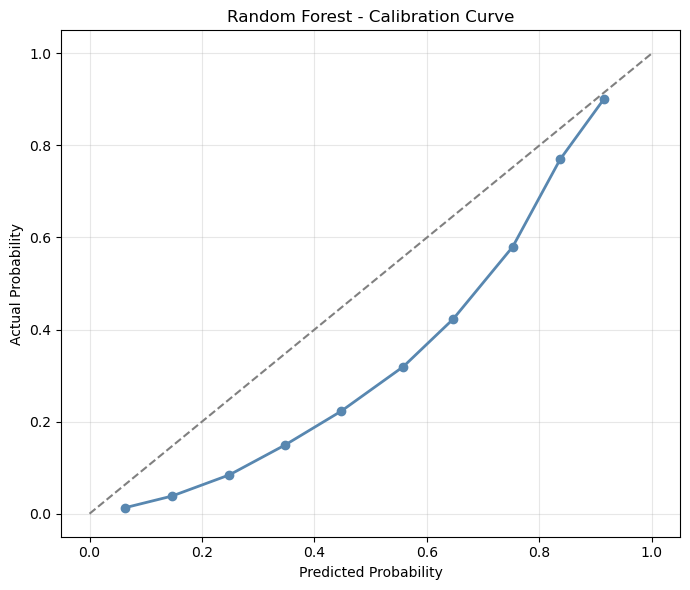

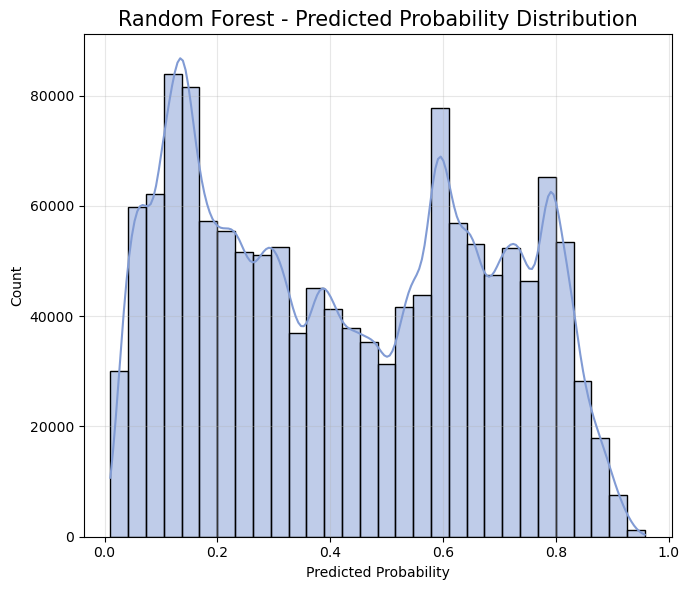

(array([1, 1, 0, ..., 0, 1, 1]),
 array([0.84677638, 0.81790098, 0.12981717, ..., 0.1261182 , 0.78824955,
        0.57739929]))

In [ ]:
evaluate_model(rf, X_test, y_test, model_name="Random Forest")


SGD Classifier
Accuracy: 0.7545114911283898
Precision: 0.5706242769613094
Recall: 0.35195031712473573
F1 Score: 0.4353716144428644
AUC: 0.776247771439741
Brier Score: 0.15979060534726794

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84   1028729
           1       0.57      0.35      0.44    378400

    accuracy                           0.75   1407129
   macro avg       0.68      0.63      0.64   1407129
weighted avg       0.73      0.75      0.73   1407129



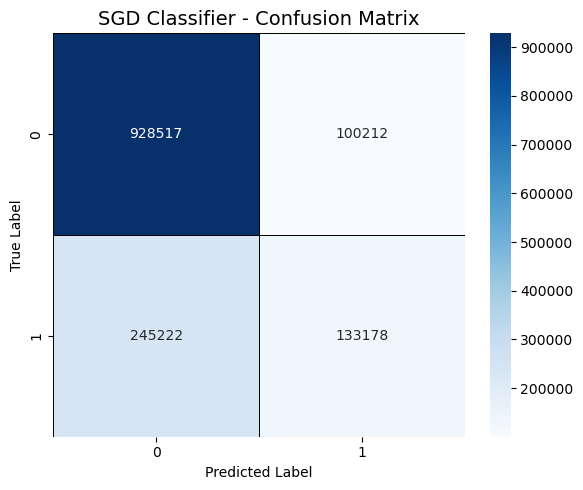

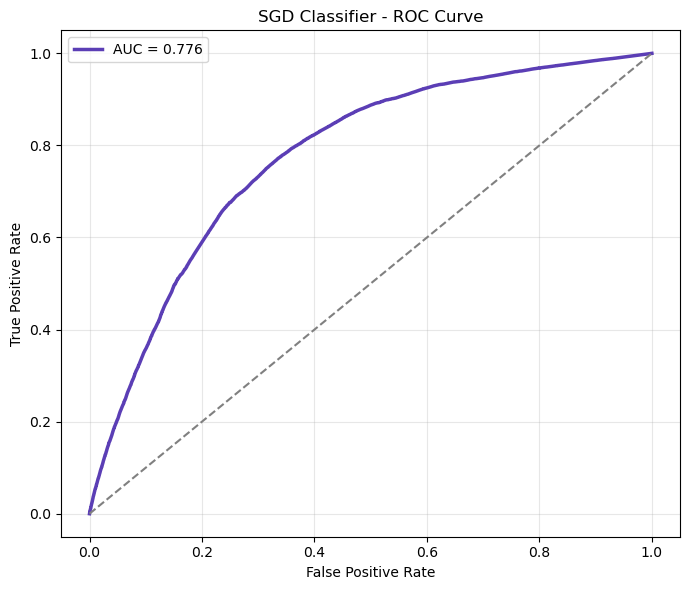

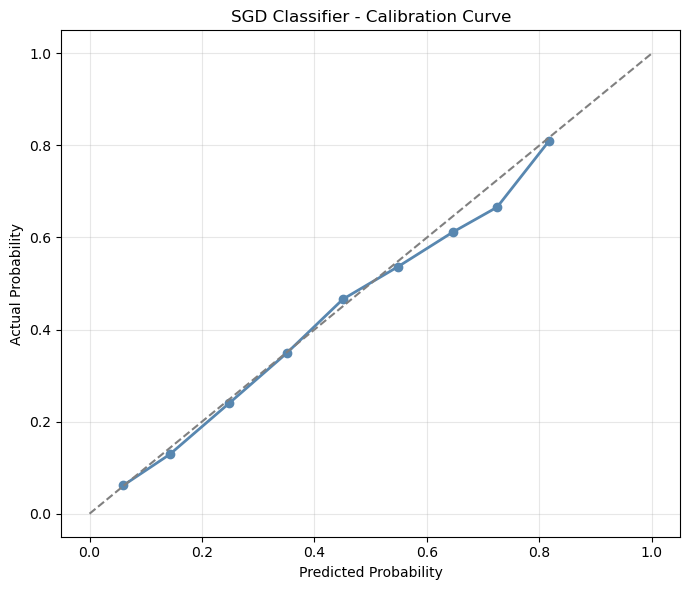

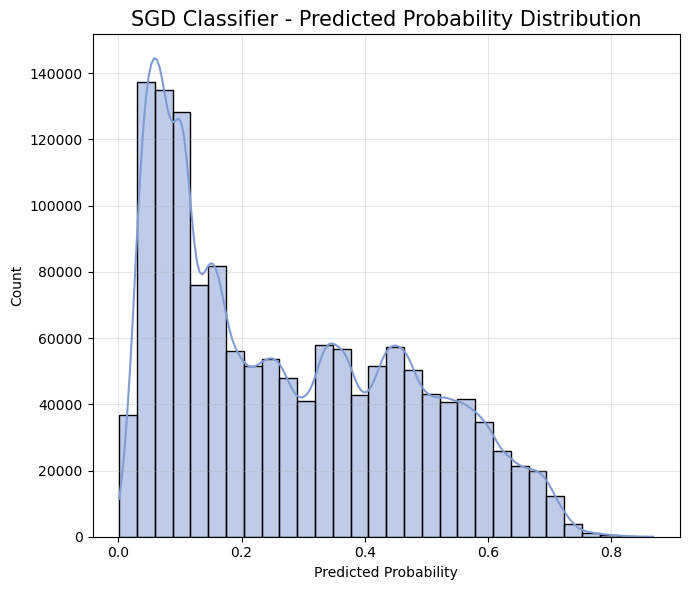

(array([1, 1, 0, ..., 0, 1, 0]),
 array([0.51995584, 0.76461196, 0.05312895, ..., 0.0420814 , 0.58889898,
        0.24323318]))

In [ ]:
evaluate_model(sgd, X_test, y_test, model_name="SGD Classifier")


LightGBM
Accuracy: 0.8030834415323684
Precision: 0.6815469470696385
Recall: 0.5025634249471459
F1 Score: 0.5785281103453311
AUC: 0.8497032854923791
Brier Score: 0.13413228185032244

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87   1028729
           1       0.68      0.50      0.58    378400

    accuracy                           0.80   1407129
   macro avg       0.76      0.71      0.73   1407129
weighted avg       0.79      0.80      0.79   1407129



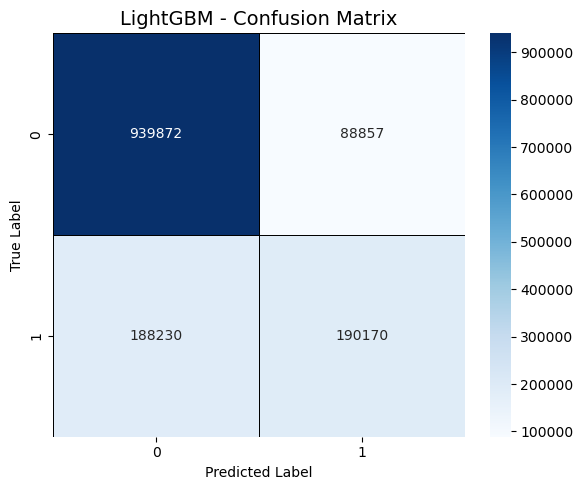

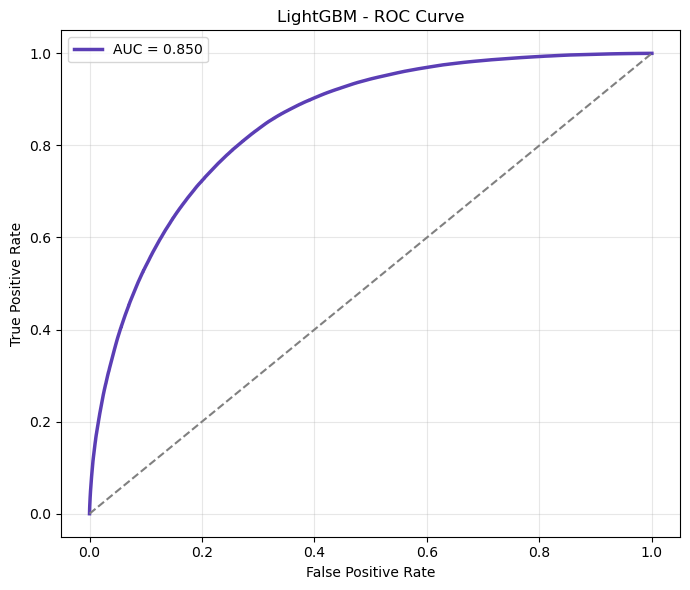

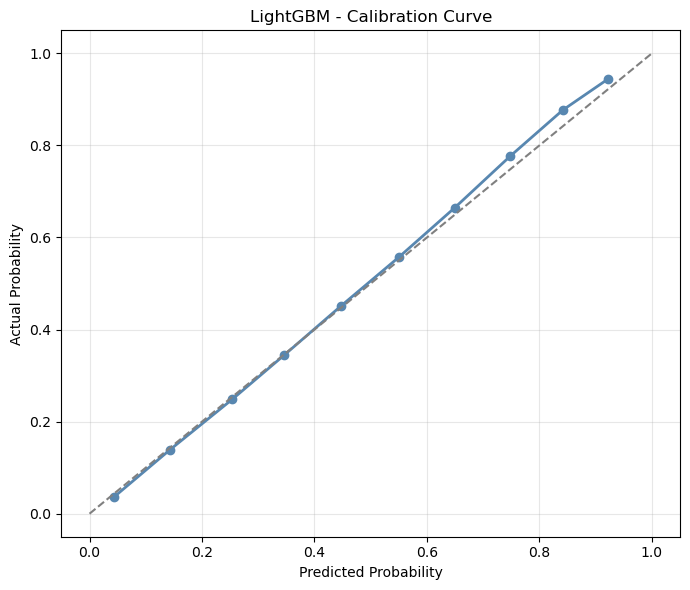

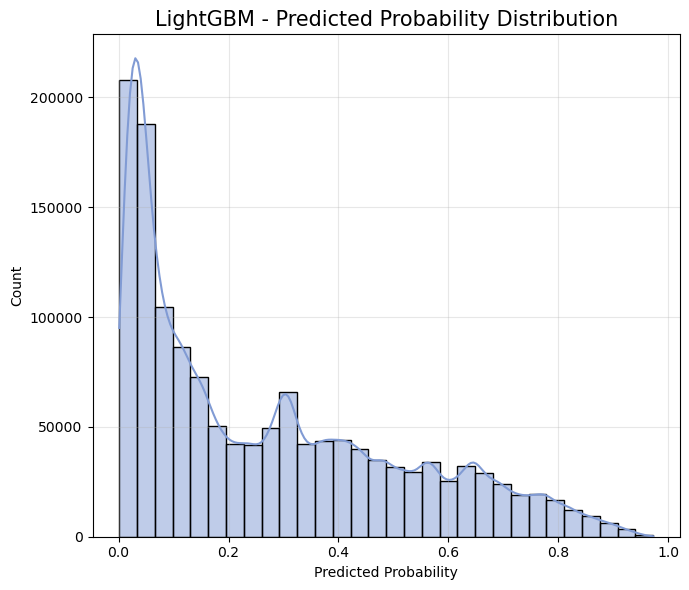

(array([1, 1, 0, ..., 0, 1, 0]),
 array([0.7821158 , 0.71610112, 0.03370658, ..., 0.03907488, 0.550507  ,
        0.34158893]))

In [ ]:
evaluate_model(lgbm, X_test, y_test, model_name="LightGBM")


CatBoost
Accuracy: 0.8012406822686478
Precision: 0.6757071357885819
Recall: 0.5016411205073996
F1 Score: 0.5758066619952011
AUC: 0.8472771892330605
Brier Score: 0.1352800234758039

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87   1028729
           1       0.68      0.50      0.58    378400

    accuracy                           0.80   1407129
   macro avg       0.75      0.71      0.72   1407129
weighted avg       0.79      0.80      0.79   1407129



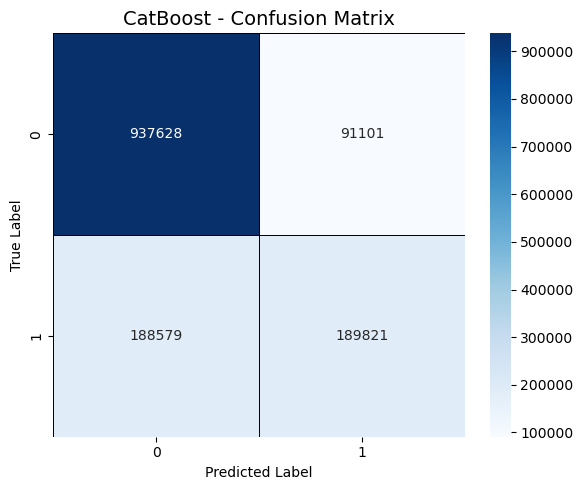

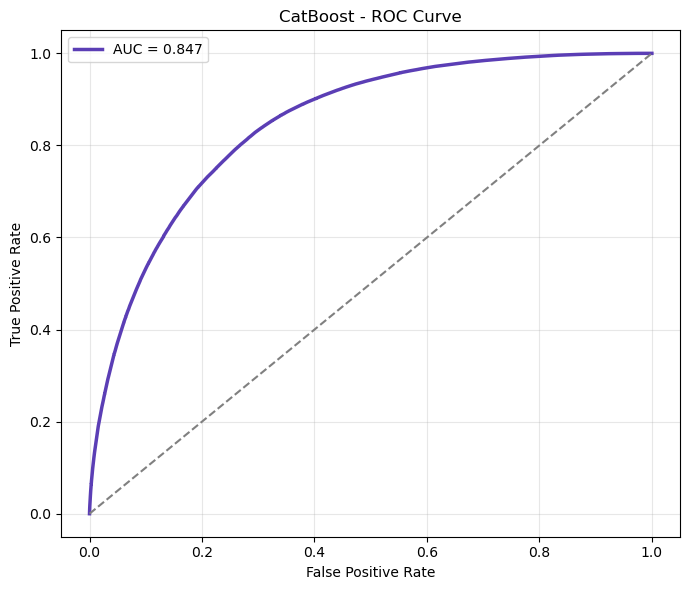

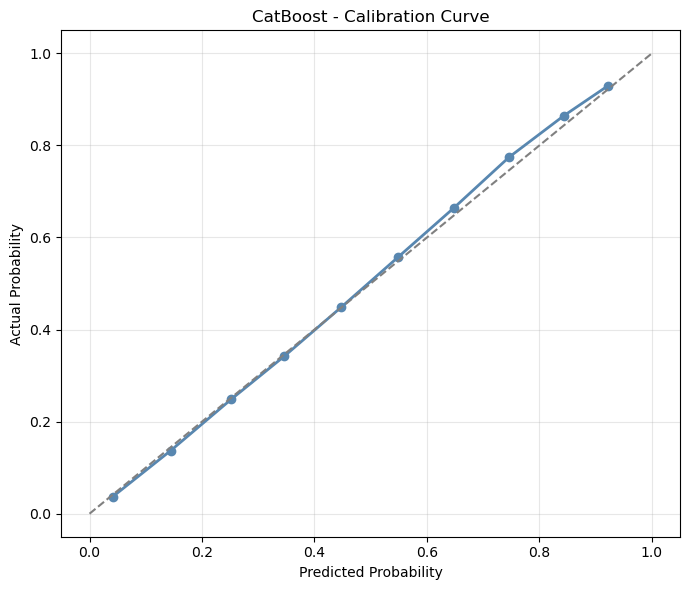

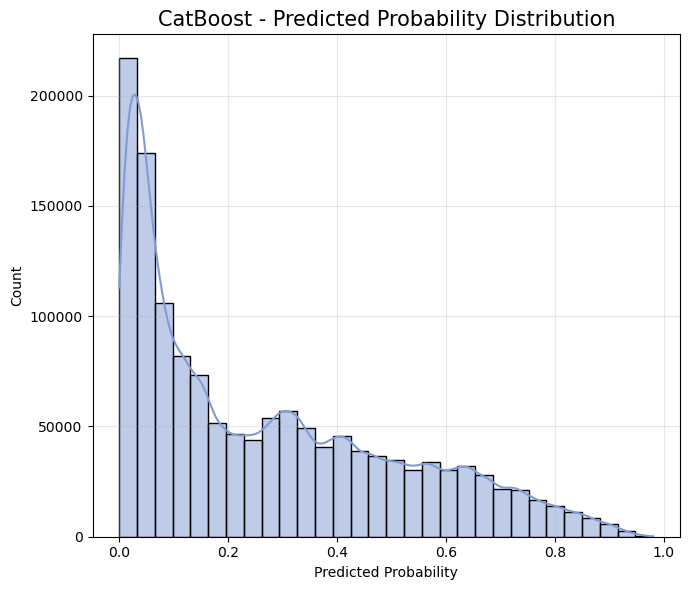

(array([1, 1, 0, ..., 0, 1, 0], dtype=int64),
 array([0.794444  , 0.74544338, 0.03833471, ..., 0.03277028, 0.57237079,
        0.35288041]))

In [ ]:
evaluate_model(cat, X_test, y_test, model_name="CatBoost")

### Feature Importance for Tree-Based Models

#### Random Forest

In [ ]:
importances = pd.Series( rf.feature_importances_, index=X_train.columns ).sort_values(ascending=False)

C:\Users\janec\AppData\Local\Temp\ipykernel_22152\1621494152.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


NameError: name 'model_name' is not defined

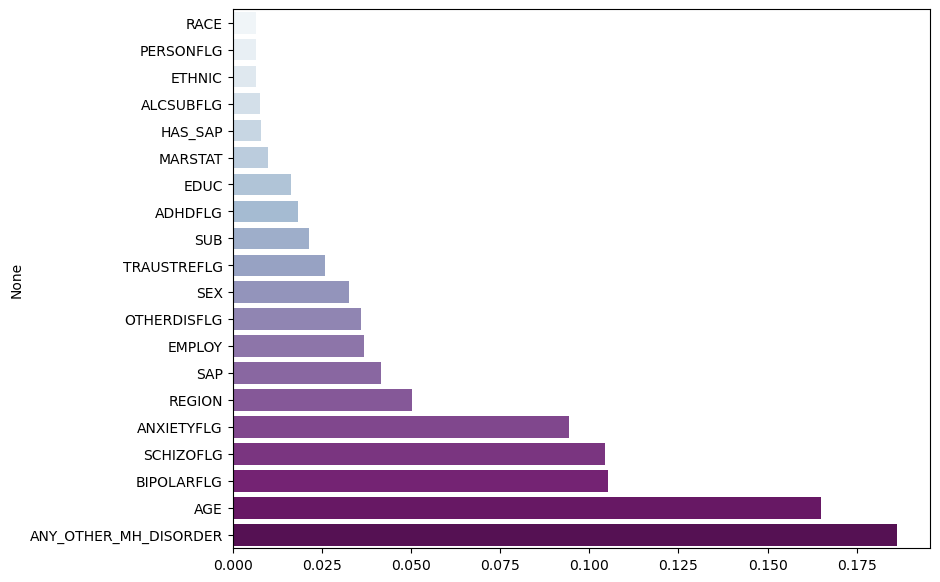

In [ ]:
top = importances.head(20).sort_values()

plt.figure(figsize=(9, 7))
sns.barplot(
x=top.values,
y=top.index,
        palette="BuPu"
    )
plt.title(f"{model_name} Feature Importance", fontsize=16)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

#### LightGBM

C:\Users\janec\AppData\Local\Temp\ipykernel_22152\774043796.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


NameError: name 'model_name' is not defined

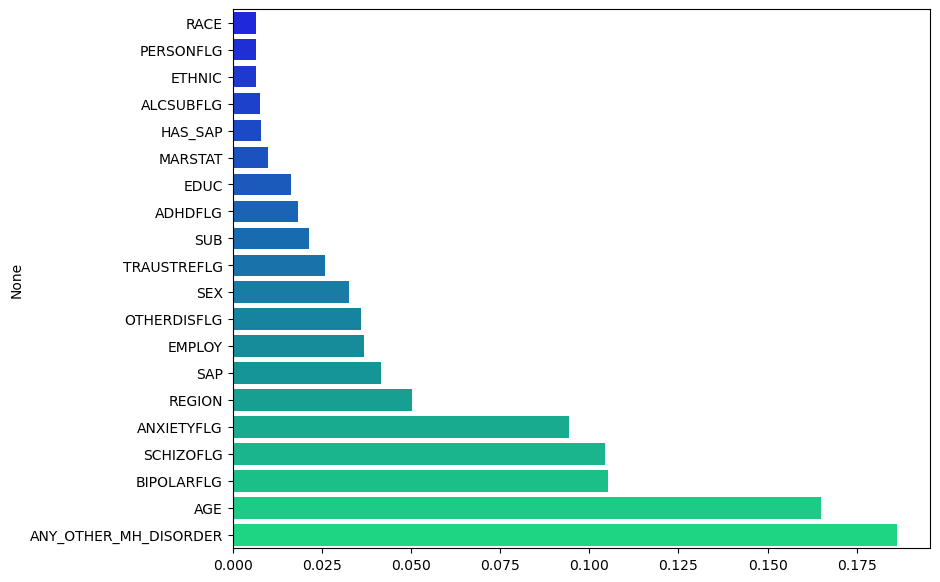

In [ ]:
lgbm_importances = pd.Series(
    lgbm.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

top = importances.head(20).sort_values()

plt.figure(figsize=(9, 7))
sns.barplot(
        x=top.values,
        y=top.index,
        palette="winter"
    )

plt.title(f"{model_name} Feature Importance", fontsize=16)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

#### CatBoost

In [ ]:
# Getting feature importance values from CatBoost model
cat_importances = cat.get_feature_importance(prettified=True)
print(cat_importances)

               Feature Id  Importances
0              ANXIETYFLG    16.719575
1             TRAUSTREFLG    12.894044
2              BIPOLARFLG     9.354021
3             OTHERDISFLG     8.932102
4                 ADHDFLG     8.438186
5   ANY_OTHER_MH_DISORDER     7.262891
6                     AGE     6.918724
7               SCHIZOFLG     5.516353
8                  REGION     4.860434
9                     SAP     3.154797
10              PERSONFLG     2.617967
11                 EMPLOY     2.004440
12              ALCSUBFLG     1.979324
13                 ODDFLG     1.752672
14                 PDDFLG     1.527743
15                    SUB     1.312531
16                   EDUC     1.112122
17                    SEX     0.738015
18                HAS_SAP     0.572198
19                   RACE     0.529024
20                 ETHNIC     0.496741
21             CONDUCTFLG     0.466940
22                MARSTAT     0.386690
23                LIVARAG     0.305850
24            DELIRDEMFLG

In [ ]:
# Converting to pandas series
imp_series = pd.Series(
    cat_importances["Importances"].values,
    index=cat_importances["Feature Id"].values
).sort_values(ascending=True)

C:\Users\janec\AppData\Local\Temp\ipykernel_22152\738050054.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


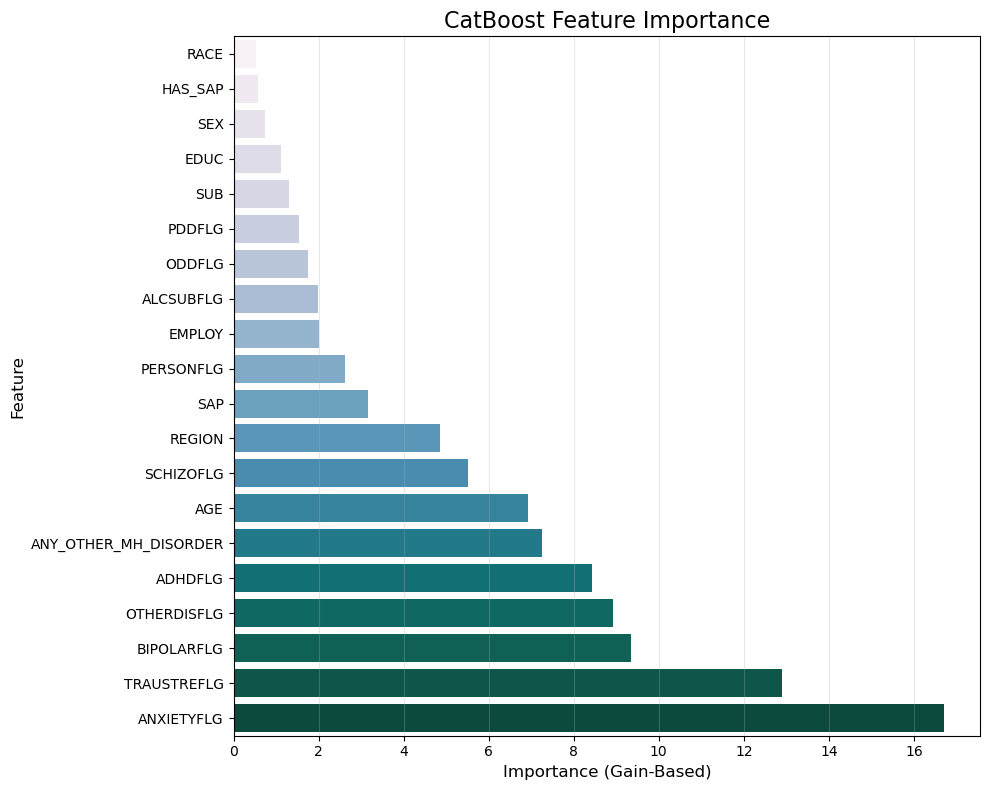

In [ ]:
# Plotting top 20 most important features
top = imp_series.tail(20)

plt.figure(figsize=(10, 8))
sns.barplot(
    x=top.values,
    y=top.index,
    palette="PuBuGn"
)

plt.title("CatBoost Feature Importance", fontsize=16)
plt.xlabel("Importance (Gain-Based)", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Plotting bottom 20 features


### Feature Effects (SGD)

In [ ]:
# Getting feature effects values from sgd model
sgd.named_steps["sgd"].coef_
sgd = sgd.named_steps["sgd"]

# Converting to pandas series
coefs = pd.Series(
    sgd.coef_[0],
    index=X_train.columns
).sort_values()

C:\Users\janec\AppData\Local\Temp\ipykernel_22152\203848772.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_pos.values, y=top_pos.index, palette="Blues")


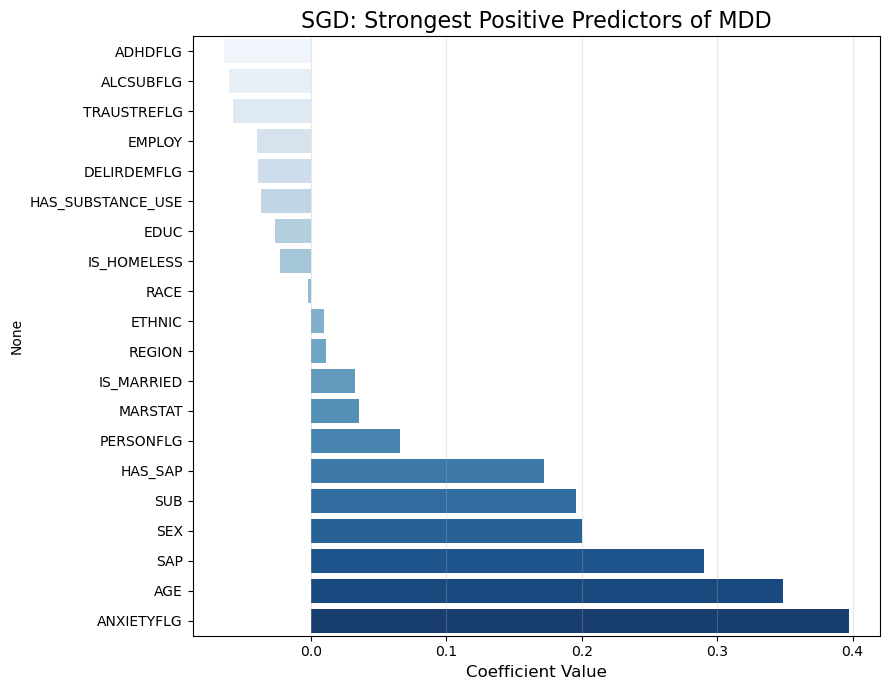

In [ ]:
top_pos = coefs.tail(20).sort_values()

plt.figure(figsize=(9,7))
sns.barplot(x=top_pos.values, y=top_pos.index, palette="Blues")
plt.title("SGD: Strongest Positive Predictors of MDD", fontsize=16)
plt.xlabel("Coefficient Value", fontsize=12)
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

C:\Users\janec\AppData\Local\Temp\ipykernel_22152\1493180783.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_neg.values, y=top_neg.index, palette="Purples")


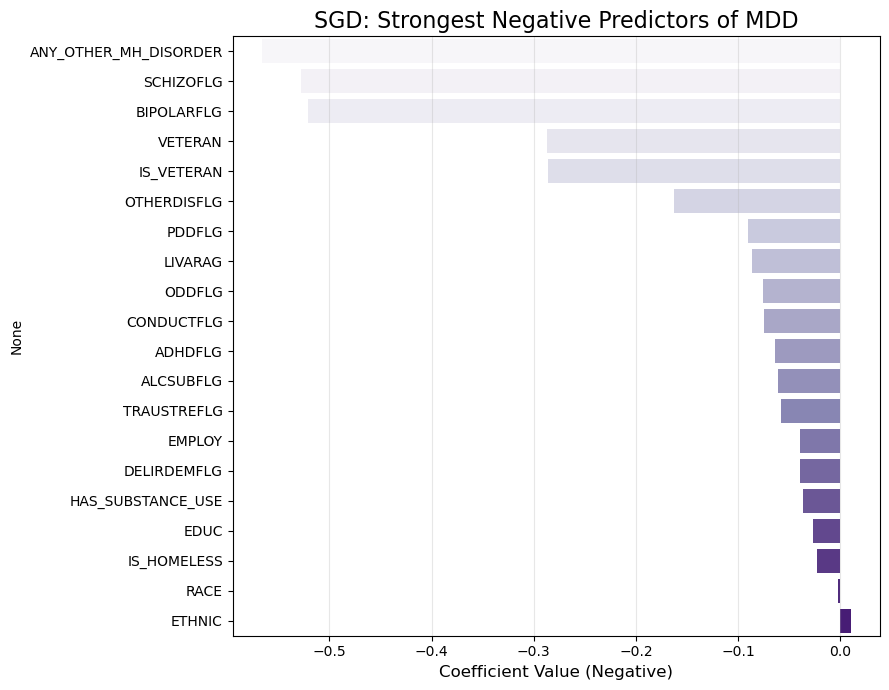

In [ ]:
top_neg = coefs.head(20).sort_values()

plt.figure(figsize=(9,7))
sns.barplot(x=top_neg.values, y=top_neg.index, palette="Purples")
plt.title("SGD: Strongest Negative Predictors of MDD", fontsize=16)
plt.xlabel("Coefficient Value (Negative)", fontsize=12)
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()